# Heart Attack Prediction

### Programmazione di Applicazioni Data Intensive
**Lorenzo Dall'Ara**, lorenzo.dallara2@studio.unibo.it\
**Miriam Sonaglia**, miriam.sonaglia@studio.unibo.it

### Fonti Dataset:
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-dataset-of-china \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-united-states \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-and-prediction-dataset-in-india/data \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-indonesia

## Obiettivo del progetto
Questo progetto si pone l'obiettivo di realizzare un modello in grado di predire, in base a caratteristiche proprie del paziente, un possibile rischio di infarto.

## Import delle librerie
Vengono importate le librerie sotto descritte:
* **NumPy** per il calcolo numerico e la gestione di array
* **Pandas** per manipolazione e gestione di dati tabellari
* **Seaborn** e **Matplotlib** per la creazione di grafici
* **Sklearn** per l'analisi predittiva, il preprocessing dei dati, la costruzione di pipeline e la valutazione delle performance
  * modelli di regressione e classificazione (**Logistic Regression**, **Elastic Net**)  
  * trasformazioni delle feature (**StandardScaler**, **PolynomialFeatures**, **OneHotEncoder**)  
  * suddivisione del dataset e ottimizzazione degli iperparametri (**Train/Test Split**, **GridSearchCV**)  
  * metriche di valutazione per modelli di classificazione
* **XGBoost** per la costruzione di modelli basati su gradient boosting

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix,
    precision_score, recall_score, f1_score,
    accuracy_score, matthews_corrcoef
)

## Caricamento e Preprocessing dei dati

In [27]:
CHINA_DATASET = "heart_attack_china.csv"
US_DATASET = "heart_attack_us.csv"
INDIA_DATASET = "heart_attack_india.csv"
INDONESIA_DATASET = "heart_attack_indonesia.csv"
china = pd.read_csv(CHINA_DATASET, sep=",")
unitedStates = pd.read_csv(US_DATASET, sep=",")
india = pd.read_csv(INDIA_DATASET, sep=",")
indonesia = pd.read_csv(INDONESIA_DATASET, sep=",")

In [ ]:
def memory_benchmark_df(starting_memory: pd.Series, optimized_memory: pd.Series) ->  pd.DataFrame:
    df = pd.DataFrame()
    df['Initial (Bytes)'] = starting_memory
    df['After (Bytes)'] = optimized_memory
    df['Optimization'] = optimized_memory / starting_memory
    total_starting_memory = starting_memory.sum()
    total_end_memory = optimized_memory.sum()
    df.loc['Totale (Bytes)'] = [
        total_starting_memory,
        total_end_memory,
        total_end_memory / total_starting_memory
    ]
    return df

In [ ]:
# !!!!!SE NON UTILIZZATI OLTRE A PRINT DATAFRAME RIMUOIVERE!!!!!!
china_memory_df = pd.DataFrame()
us_memory_df = pd.DataFrame()
india_memory_df = pd.DataFrame()
indonesia_memory_df = pd.DataFrame()

### Scelta e Denominazione delle colonne
Si è proceduto alla selezione delle variabili compatibili tra i quattro dataset, individuandone le colonne comuni e rinominandole in modo univoco.

Le colonne scelte sono quindi:
* **PatientID**: identificatore univoco del paziente
* **Age**: età del paziente
* **Gender**: genere del paziente, può assumere i valori "Male" o "Female"
* **IncomeLevel**: guadagno annuo del paziente, può assumere i valori "Low", "Middle" o "High"
* **Hypertension**: indica se il paziente soffre o meno di ipertensione arteriosa
* **Diabetes**: indica se il paziente soffre o meno di diabete
* **Cholesterol**: indica il livello di colesterolo del paziente, può assumere i valori "Low", "Normal" o "High"
* **Obesity**: indica se il paziente sia affetto o meno da obesità
* **FamilyHistory**: indica se qualche membro della famiglia del paziente abbia avuto o meno un infarto in passato
* **Smoker**: indica se il paziente sia o meno un fumatore
* **AlcoholConsumption**: indica se il paziente sia tendente o meno al consumo di alcohol
* **PhysicalActivity**: indica se il paziente svolge o meno attività fisica
* **HealthyDiet**: indica se il paziente segua o meno una dieta sana
* **StressLevel**: indica il livello di stress del paziente, può assumere i valori 'Low', 'Moderate' o 'High'
* **BloodPressure**: indica il valore della pressione sistolica del paziente
* **PreviousHeartAttack**: indica se il paziente abbia avuto o meno altri infarti in passato
* **Outcome**: indica se il paziente abbia avuto o meno un infarto
* **State**: indica lo stato di provenienza del paziente (Cina, Stati Uniti, India, Indonesia)

In [29]:
china['State'] = "China"
india['State'] = "India"
unitedStates['State'] = "United States"
indonesia['State'] = "Indonesia"

unitedStates["PatientID"] = range(1, len(unitedStates)+1)
indonesia["PatientID"] = range(1, len(indonesia)+1)

In [ ]:
(
    unitedStates.drop(
        columns = ['EducationLevel',
                   'ST_Depression',
                   'EmploymentStatus',
                   'MaritalStatus',
                   'Ethnicity',
                   'Medication',
                   'ChestPainType',
                   'ECGResults',
                   'ExerciseInducedAngina',
                   'Slope',
                   'NumberOfMajorVessels',
                   'Thalassemia',
                   'StrokeHistory',
                   'Residence',
                   'MaxHeartRate',
                   'HeartRate'
                  ],
        inplace=True
    )
)

unitedStates.rename(
    columns = {
        'BMI':'Obesity',
        'Income':'IncomeLevel',
        'Patient_ID':'PatientID',
        'Diet':'HealthyDiet'
    },
    inplace=True)

In [31]:
(
    china.drop(
        columns = ['Education_Level',
                   'Employment_Status',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Rural_or_Urban',
                   'Region',
                   'Province',
                   'Hospital_Availability',
                   'TCM_Use',
                   'Chronic_Kidney_Disease',
                   'CVD_Risk_Score'
                  ],
        inplace=True
    )
)

china.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking_Status':'Smoker',
        'Cholesterol_Level':'Cholesterol',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Income_Level':'IncomeLevel',
        'Blood_Pressure':'BloodPressure',
        'Previous_Heart_Attack': 'PreviousHeartAttack',
        'Family_History_CVD': 'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Heart_Attack' : 'Outcome'
    },
    inplace=True
)

In [32]:
(
    india.drop(
        columns = ['State_Name',
                   'Triglyceride_Level',
                   'LDL_Level',
                   'HDL_Level',
                   'Diastolic_BP',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Emergency_Response_Time',
                   'Health_Insurance'
                  ],
        inplace=True
    )
)

india.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking':'Smoker',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Cholesterol_Level':'Cholesterol',
        'Systolic_BP':'BloodPressure',
        'Family_History':'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Heart_Attack_History':'PreviousHeartAttack',
        'Annual_Income':'IncomeLevel',
        'Heart_Attack_Risk':'Outcome'
    },
    inplace=True
)

In [33]:
(
    indonesia.drop(
        columns = ['region',
                   'waist_circumference',
                   'air_pollution_exposure',
                   'sleep_hours',
                   'blood_pressure_diastolic',
                   'fasting_blood_sugar',
                   'cholesterol_hdl',
                   'cholesterol_ldl',
                   'triglycerides',
                   'EKG_results',
                   'medication_usage',
                   'participated_in_free_screening'
                  ],
        inplace=True
    )
)

indonesia.rename(
    columns = {
        'age':'Age',
        'gender':'Gender',
        'income_level': 'IncomeLevel',
        'hypertension':'Hypertension',
        'diabetes':'Diabetes',
        'cholesterol_level':'Cholesterol',
        'obesity':'Obesity',
        'family_history':'FamilyHistory',
        'smoking_status':'Smoker',
        'alcohol_consumption':'AlcoholConsumption',
        'physical_activity':'PhysicalActivity',
        'dietary_habits':'HealthyDiet',
        'stress_level':'StressLevel',
        'blood_pressure_systolic':'BloodPressure',
        'previous_heart_disease':'PreviousHeartAttack',
        'heart_attack':'Outcome',
    },
    inplace=True
)

In [34]:
dfs = {
    "China": china,
    "India": india,
    "United States": unitedStates,
    "Indonesia" : indonesia
}

# insieme di tutte le colonne
all_columns = set().union(*(df.columns for df in dfs.values()))

# colonne mancanti per ogni dataset
diff_columns = {
    name: sorted(all_columns - set(df.columns))
    for name, df in dfs.items()
}
diff_columns

{'China': [], 'India': [], 'United States': [], 'Indonesia': []}

### Ottimizzazione e Uniformazione dei tipi di dato
Si è proceduto alla standardizzazione del formato dei dati per ogni colonna, al fine di prevenire incongruenze durante l'elaborazione.\
Inoltre, al fine di migliorare l'efficienza computazionale, è stato effettuato il downcasting di alcune variabili numeriche, convertendo il formato da `int64` a `int16` o `int32` riducendo così il peso complessivo del database.\
Per ogni stato viene creato un Dataframe che confronta l'utilizzo di memoria iniziale con quello finale dopo le modifiche apportate.

In [ ]:
initial_memory = china.memory_usage(deep=True)

# Casting Numerici
china['Age'] = china['Age'].astype('int16')
china['BloodPressure'] = china['BloodPressure'].astype('int16')
china["Obesity"] = china["Obesity"].map({"Yes": 32, "No": 24}).astype('int16')
china['Cholesterol'] = china['Cholesterol'].map({"Low":150,"Normal":200, "High":250}).astype('int16')
china['IncomeLevel'] = china['IncomeLevel'].map({'Low': 15_000, "Middle": 25_000, "High": 40_000}).astype('int32')

# Casting Categorici
china['State'] = china['State'].astype('category')
china['Gender'] = china['Gender'].astype('category')
china['StressLevel'] = china['StressLevel'].map({'Low':'Low', 'Medium':'Moderate', 'High':'High'}).astype('category')

# Casting Booleani
china['Outcome'] = china['Outcome'].map({'Yes':True, 'No':False}).astype('bool')
china["Diabetes"] = china["Diabetes"].map({"Yes": True, "No": False}).astype('bool')
china['Smoker'] = china['Smoker'].map({'Smoker':True, 'Non-Smoker':False}).astype('bool')
china["Hypertension"] = china["Hypertension"].map({"Yes": True, "No": False}).astype('bool')
china['FamilyHistory'] = china['FamilyHistory'].map({'Yes':True, 'No':False}).astype('bool')
china['HealthyDiet'] = china['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Poor": False})
china['AlcoholConsumption'] = china['AlcoholConsumption'].map({'Yes':True, 'No':False}).astype('bool')
china['PhysicalActivity'] = china['PhysicalActivity'].map({"High": True, "Medium": True, "Low": False})
china['PreviousHeartAttack'] = china['PreviousHeartAttack'].map({'Yes':True, 'No':False}).astype('bool')

end_memory = china.memory_usage(deep=True)

In [ ]:
'''
china_memory_df['Initial (Bytes)'] = initial_memory
china_memory_df['After (Bytes)'] = end_memory
china_memory_df['Optimization'] = end_memory / initial_memory
china_memory_df.loc['Totale (Bytes)'] = [
    initial_memory.sum(),
    end_memory.sum(),
    end_memory.sum() / initial_memory.sum()
]
china_memory_df
'''
memory_benchmark_df(starting_memory=initial_memory, optimized_memory=end_memory)

,Initial,After,Optimization
Index,132.0,132.0,1.000000
PatientID,1914128.0,1914128.0,1.000000
Age,1914128.0,478532.0,0.250000
Gender,12920994.0,239482.0,0.018534
Smoker,13638418.0,239266.0,0.017544
Hypertension,12267275.0,239266.0,0.019504
Diabetes,12229038.0,239266.0,0.019565
Obesity,12274311.0,478532.0,0.038986
Cholesterol,12761725.0,478532.0,0.037497
PhysicalActivity,12760872.0,239266.0,0.018750


In [ ]:
initial_memory = unitedStates.memory_usage(deep=True)

# Casting Numerici
unitedStates['Age'] = unitedStates['Age'].astype('int16')
unitedStates['Obesity'] = unitedStates['Obesity'].astype('int16')
unitedStates["IncomeLevel"] = unitedStates["IncomeLevel"].astype('int32')
unitedStates['Cholesterol'] = unitedStates['Cholesterol'].astype('int16')
unitedStates['BloodPressure'] = unitedStates['BloodPressure'].astype('int16')

# Casting Categorici
unitedStates['Gender'] = unitedStates['Gender'].astype('category')
bins = [0, 2, 4, 10]
labels = ['Low', 'Moderate', 'High']
unitedStates['StressLevel'] = pd.cut(
    unitedStates['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

# Casting Booleani
unitedStates['PhysicalActivity'] = unitedStates['PhysicalActivity'] > 2
unitedStates['AlcoholConsumption'] = unitedStates['AlcoholConsumption'] > 2
unitedStates['Smoker'] = unitedStates['Smoker'].map({1:True, 0:False}).astype('bool')
unitedStates['Diabetes'] = unitedStates['Diabetes'].map({1:True, 0:False}).astype('bool')
unitedStates['Hypertension'] = unitedStates['Hypertension'].map({1:True, 0:False}).astype('bool')
unitedStates['FamilyHistory'] = unitedStates['FamilyHistory'].map({1:True, 0:False}).astype('bool')
unitedStates['PreviousHeartAttack'] = unitedStates['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
unitedStates['Outcome'] = unitedStates['Outcome'].map({'Heart Attack':True, 'No Heart Attack':False}).astype('bool')
unitedStates['HealthyDiet'] = unitedStates['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Unhealthy": False})

end_memory = unitedStates.memory_usage(deep=True)

In [ ]:
'''
us_memory_df['Initial (Bytes)'] = initial_memory
us_memory_df['After (Bytes)'] = end_memory
us_memory_df['Optimization'] = end_memory / initial_memory
us_memory_df.loc['Totale (Bytes)'] = [
    initial_memory.sum(),
    end_memory.sum(),
    end_memory.sum() / initial_memory.sum()
]
us_memory_df
'''
memory_benchmark_df(starting_memory=initial_memory, optimized_memory=end_memory)


,Initial,After,Optimization
Index,132.0,132.0,1.000000
Age,2983792.0,745948.0,0.250000
Gender,20140030.0,373190.0,0.018530
Cholesterol,2983792.0,745948.0,0.250000
BloodPressure,2983792.0,745948.0,0.250000
Obesity,2983792.0,745948.0,0.250000
Smoker,2983792.0,372974.0,0.125000
Diabetes,2983792.0,372974.0,0.125000
Hypertension,2983792.0,372974.0,0.125000
FamilyHistory,2983792.0,372974.0,0.125000


In [ ]:
initial_memory = india.memory_usage(deep=True)

# Casting Numerici
india['Age'] = india['Age'].astype('int16')
india['Cholesterol'] = india['Cholesterol'].astype('int16')
india["IncomeLevel"] = india["IncomeLevel"].astype('int32')
india['BloodPressure'] = india['BloodPressure'].astype('int16')
india['Obesity'] = india['Obesity'].map({1:32, 0:24}).astype('int16')

# Casting Categorici
india['Gender'] = india['Gender'].astype('category')
bins = [0, 3, 7, 11]
labels = ['Low', 'Moderate', 'High']
india['StressLevel'] = pd.cut(
    india['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')
india['State'] = india['State'].astype('category')

# Casting Booleani
india['HealthyDiet'] = india['HealthyDiet'] > 4
india['Smoker'] = india['Smoker'].map({1:True, 0:False}).astype('bool')
india['Outcome'] = india['Outcome'].map({1:True, 0:False}).astype('bool')
india['Diabetes'] = india['Diabetes'].map({1:True, 0:False}).astype('bool')
india['Hypertension'] = india['Hypertension'].map({1:True, 0:False}).astype('bool')
india['FamilyHistory'] = india['FamilyHistory'].map({1:True, 0:False}).astype('bool')
india['PhysicalActivity'] = india['PhysicalActivity'].map({1:True, 0:False}).astype('bool')
india['AlcoholConsumption'] = india['AlcoholConsumption'].map({1:True, 0:False}).astype('bool')
india['PreviousHeartAttack'] = india['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')

end_memory = india.memory_usage(deep=True)

In [ ]:
'''india_memory_df['Initial (Bytes)'] = initial_memory
india_memory_df['After (Bytes)'] = end_memory
india_memory_df['Optimization'] = end_memory / initial_memory
india_memory_df.loc['Totale (Bytes)'] = [
    initial_memory.sum(),
    end_memory.sum(),
    end_memory.sum() / initial_memory.sum()
]
india_memory_df'''

memory_benchmark_df(starting_memory=initial_memory, optimized_memory=end_memory)

,Initial,After,Optimization
Index,132.0,132.0,1.000000
PatientID,80000.0,80000.0,1.000000
Age,80000.0,20000.0,0.250000
Gender,538968.0,10216.0,0.018955
Diabetes,80000.0,10000.0,0.125000
Hypertension,80000.0,10000.0,0.125000
Obesity,80000.0,20000.0,0.250000
Smoker,80000.0,10000.0,0.125000
AlcoholConsumption,80000.0,10000.0,0.125000
PhysicalActivity,80000.0,10000.0,0.125000


In [ ]:
initial_memory = indonesia.memory_usage(deep=True)

# Casting Numerici
indonesia['Age'] = indonesia['Age'].astype('int16')
indonesia['Cholesterol'] = indonesia['Cholesterol'].astype('int16')
indonesia['BloodPressure'] = indonesia['BloodPressure'].astype('int16')
indonesia['Obesity'] = indonesia['Obesity'].map({1:32, 0:24}).astype('int16')
indonesia['IncomeLevel'] = indonesia['IncomeLevel'].map({'Low': 2500, "Middle": 8000, "High": 25_000}).astype('int32')

# Casting Categorici
indonesia['State'] = indonesia['State'].astype('category')
indonesia['Gender'] = indonesia['Gender'].astype('category')
indonesia['StressLevel'] = indonesia['StressLevel'].astype('category')

# Casting Booleani
indonesia['Outcome'] = indonesia['Outcome'].map({1:True, 0:False}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({1:True, 0:False}).astype('bool')
indonesia['Hypertension'] = indonesia['Hypertension'].map({1:True, 0:False}).astype('bool')
indonesia['FamilyHistory'] = indonesia['FamilyHistory'].map({1:True, 0:False}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
indonesia['PreviousHeartAttack'] = indonesia['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
indonesia['Smoker'] = indonesia['Smoker'].map({'Past':True,'Current':True, 'Never':False}).astype('bool')
indonesia['HealthyDiet'] = indonesia['HealthyDiet'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
indonesia['PhysicalActivity'] = indonesia['PhysicalActivity'].map({'Low': False, 'Moderate': True, 'High': True}).astype('bool')
indonesia['AlcoholConsumption'] = indonesia['AlcoholConsumption'].map({None: False, 'Moderate': True, 'High': True}).astype('bool')

end_memory = indonesia.memory_usage(deep=True)

In [ ]:
'''indonesia_memory_df['Initial (Bytes)'] = initial_memory
indonesia_memory_df['After (Bytes)'] = end_memory
indonesia_memory_df['Optimization'] = end_memory / initial_memory
indonesia_memory_df.loc['Totale (Bytes)'] = [
    initial_memory.sum(),
    end_memory.sum(),
    end_memory.sum() / initial_memory.sum()
]
indonesia_memory_df'''

memory_benchmark_df(starting_memory=initial_memory, optimized_memory=end_memory)

,Initial,After,Optimization
Index,132.0,132.0,1.000000
Age,1266840.0,316710.0,0.250000
Gender,8545039.0,158571.0,0.018557
IncomeLevel,8471853.0,633420.0,0.074768
Hypertension,1266840.0,158355.0,0.125000
Diabetes,1266840.0,158355.0,0.125000
Cholesterol,1266840.0,316710.0,0.250000
Obesity,1266840.0,316710.0,0.250000
FamilyHistory,1266840.0,158355.0,0.125000
Smoker,8591311.0,158355.0,0.018432


I campi `PatientID` e `State` sono identificatori univoci del paziente, senza rilevanza ai fini del modello, è stato scelto quindi di impostarli come `index`

In [43]:
china.set_index(['State','PatientID'], inplace=True)
unitedStates.set_index(['State','PatientID'], inplace=True)
india.set_index(['State','PatientID'], inplace=True)
indonesia.set_index(['State','PatientID'], inplace=True)

In [44]:
dataset = pd.concat([china, india, unitedStates, indonesia], verify_integrity=False)
dataset['StressLevel'] = dataset['StressLevel'].astype('category')

### Verifica dei record dal valore `NaN`

In [ ]:
dataset.isna().mean() * 100

Age                    0.0
Gender                 0.0
Smoker                 0.0
Hypertension           0.0
Diabetes               0.0
Obesity                0.0
Cholesterol            0.0
PhysicalActivity       0.0
HealthyDiet            0.0
StressLevel            0.0
AlcoholConsumption     0.0
FamilyHistory          0.0
IncomeLevel            0.0
BloodPressure          0.0
PreviousHeartAttack    0.0
Outcome                0.0
dtype: float64

### Verifica dello sbilanciamento del dataset
Viene ora effettuata una verifica dello sbilanciamento del dataset per evitare di incorrere in previsioni influenzate dalla prevalenza statistica di alcune classi rispetto ad altre.\
Una distribuzione non uniforme, infatti, potrebbe introdurre distorsioni (bias) nelle fasi di training.\
Per garantire che il modello finale sia in grado di generalizzare correttamente su tutte le categorie è quindi fondamentale identificare eventuali squilibri.

<Axes: ylabel='count'>

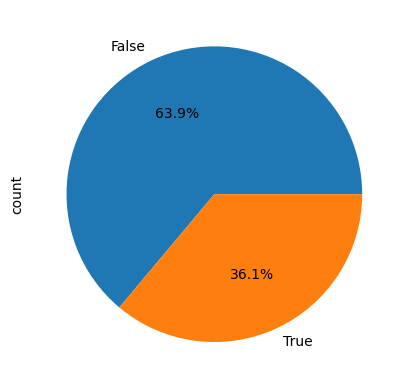

In [47]:
dataset['Outcome'].value_counts().plot.pie(autopct="%.1f%%")

In [48]:
dataset.groupby('Outcome').describe().transpose().round(2)

Outcome                   False       True 
Age           count   498700.00   281895.00
              mean        57.27       56.94
              std         16.01       15.36
              min         20.00       20.00
              25%         44.00       44.00
              50%         57.00       57.00
              75%         70.00       69.00
              max         90.00       90.00
Obesity       count   498700.00   281895.00
              mean        27.04       27.90
              std          4.92        5.68
              min         18.00       18.00
              25%         24.00       24.00
              50%         24.00       27.00
              75%         32.00       32.00
              max         40.00       40.00
Cholesterol   count   498700.00   281895.00
              mean       199.51      200.78
              std         47.53       52.90
              min        100.00      100.00
              25%        150.00      156.00
              50%        200.00      200.00
              75%        250.00      247.00
              max        350.00      350.00
IncomeLevel   count   498700.00   281895.00
              mean     68283.01    88381.74
              std     142237.52   129263.22
              min       2500.00     2500.00
              25%      15000.00    25000.00
              50%      34287.00    66881.00
              75%      86386.50   134892.00
              max    1999714.00  1999521.00
BloodPressure count   498700.00   281895.00
              mean       133.56      133.39
              std         24.35       24.06
              min         61.00       71.00
              25%        114.00      114.00
              50%        133.00      133.00
              75%        153.00      152.00
              max        199.00      194.00

* La distribuzione dell'età molto simile tra i gruppi può indicare un basso potere discriminante.
* **Obesity** presenta valori medi e mediani più elevati per Outcome = True,
  indicando una possibile associazione positiva.
* **IncomeLevel** evidenzia una differenza significativa tra Outcome = True e False, ma con una forte dispersione e quindi possibili outlier.

### Verifica della presenza di valori outlier

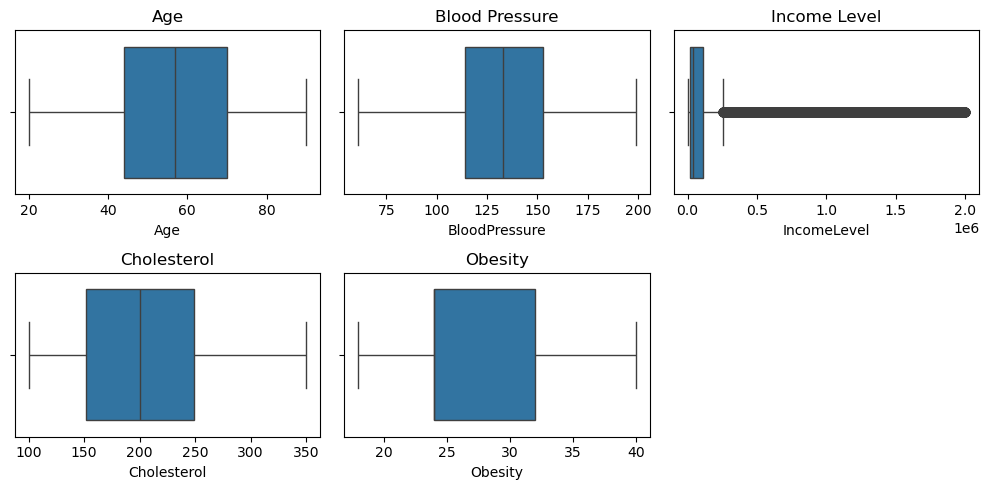

In [49]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 3, 1)
sb.boxplot(x="Age", data=dataset)
plt.title("Age")

plt.subplot(2, 3, 2)
sb.boxplot(x="BloodPressure", data=dataset)
plt.title("Blood Pressure")

plt.subplot(2, 3, 3)
sb.boxplot(x="IncomeLevel", data=dataset)
plt.title("Income Level")

plt.subplot(2, 3, 4)
sb.boxplot(x="Cholesterol", data=dataset)
plt.title("Cholesterol")

plt.subplot(2, 3, 5)
sb.boxplot(x="Obesity", data=dataset)
plt.title("Obesity")

plt.tight_layout()
plt.show()


Come precedentemente ipotizzato, si può notare l'evidente presenza di outliers nella feature **IncomeLevel**.\
Si procede quindi ad un'analisi più approfondita della feature calcolandone i valori massimi e minimi per ogni stato.

In [50]:
maxIncomeSeries = dataset.groupby('State')['IncomeLevel'].max()
minIncomeSeries = dataset.groupby('State')['IncomeLevel'].min()
print(maxIncomeSeries, '\n')
print(minIncomeSeries)

State
China              40000
India            1999714
Indonesia          25000
United States     199999
Name: IncomeLevel, dtype: int32 

State
China            15000
India            50353
Indonesia         2500
United States    20000
Name: IncomeLevel, dtype: int32


#### Normalizzazione delle variabili
Per rendere le variabili confrontabili tra loro e ridurre l’impatto delle diverse scale, è stato scelto di applicare la **normalizzazione Min-Max**.
Essa permette di trasformare i valori originali nell'intervallo \([0,1]\) secondo la formula:
$$
x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$
dove:
* $x$ è il valore originale della variabile
* $x_{min}$ e $x_{max}$ sono rispettivamente il valore minimo e massimo osservati

In questo modo è possibile preservare la distribuzione dei dati, mantenendo invariate le relazioni tra i valori.

In [ ]:
dataset['IncomeLevel'] = (
    dataset.groupby('State')['IncomeLevel']
           .transform(lambda x: ((x - x.min()) / (x.max() - x.min()))*100)
)
dataset['IncomeLevel'] = dataset['IncomeLevel'].astype('int16')
dataset

Age  Gender  Smoker  Hypertension  Diabetes  Obesity  \
State     PatientID                                                         
China     1           55    Male   False         False     False       32   
          2           66  Female    True          True     False       24   
          3           69  Female    True         False     False       24   
          4           45  Female    True         False      True       24   
          5           39  Female    True         False     False       24   
...                  ...     ...     ...           ...       ...      ...   
Indonesia 158351      60  Female   False         False      True       24   
          158352      64  Female   False         False      True       24   
          158353      30    Male    True         False      True       24   
          158354      74    Male    True         False      True       24   
          158355      61    Male    True         False      True       24   

                     Cholesterol  PhysicalActivity  HealthyDiet StressLevel  \
State     PatientID                                                           
China     1                  200              True         True         Low   
          2                  150              True         True    Moderate   
          3                  150              True         True         Low   
          4                  200             False         True    Moderate   
          5                  200              True         True         Low   
...                          ...               ...          ...         ...   
Indonesia 158351             199              True         True        High   
          158352             179              True         True        High   
          158353             220             False         True    Moderate   
          158354             180             False        False        High   
          158355             190              True        False        High   

                     AlcoholConsumption  FamilyHistory  IncomeLevel  \
State     PatientID                                                   
China     1                        True          False     0.000000   
          2                       False           True    40.000000   
          3                       False          False   100.000000   
          4                        True          False     0.000000   
          5                       False          False    40.000000   
...                                 ...            ...          ...   
Indonesia 158351                   True          False    24.444444   
          158352                   True          False     0.000000   
          158353                   True          False    24.444444   
          158354                   True           True    24.444444   
          158355                   True          False    24.444444   

                     BloodPressure  PreviousHeartAttack  Outcome  
State     PatientID                                               
China     1                    104                False    False  
          2                    142                False    False  
          3                    176                False    False  
          4                    178                 True    False  
          5                    146                False    False  
...                            ...                  ...      ...  
Indonesia 158351               127                False    False  
          158352               132                False     True  
          158353               133                 True     True  
          158354               134                 True     True  
          158355               133                False    False  

[780595 rows x 16 columns]

Text(0.5, 1.0, 'Income Level')

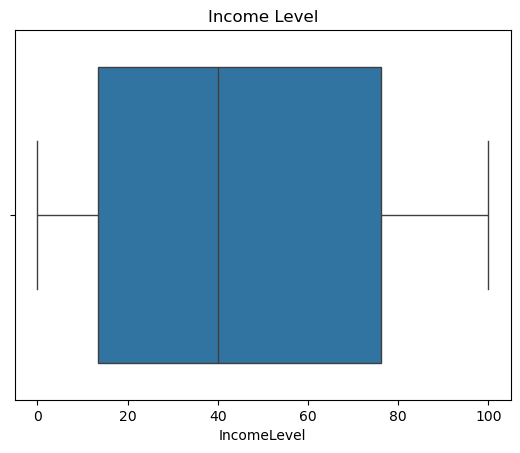

In [52]:
sb.boxplot(x="IncomeLevel", data=dataset)
plt.title("Income Level")

### Analisi dei legami tra feature
Viene ora mostrata la matrice di correlazione delle feature

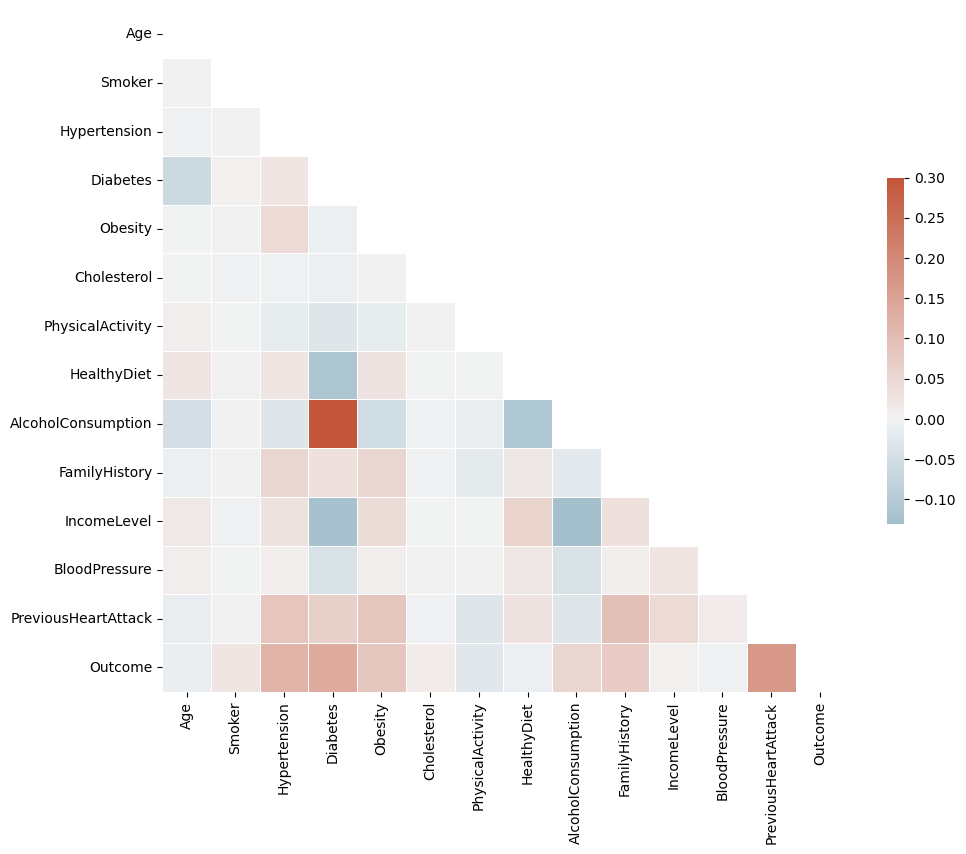

In [53]:
corrDataset = dataset.drop(columns=['Gender', 'StressLevel'])
corr_matrix = corrDataset.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sb.diverging_palette(230,20,as_cmap=True)
sb.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Le variabili che mostrano una correlazione positiva più evidente con l’Outcome sono:
* **PreviousHeartAttack**: variabile più fortemente correlata con l’Outcome. Chi ha avuto un infarto in passato ha una probabilità maggiore di averne un altro.
* **Diabetes**, **Hypertension** e **Obesity**: mostrano una correlazione positiva moderata con l’Outcome rimanendo quindi fattori di rischio per un possibile infarto.
* **FamilyHistory**: anche la presenza di registrazione di infarti passati di membri della famiglia è positivamente correlata con l'Output.

Si può inoltre notare una forte correlazione tra le feature **AlcoholConsumption** e **Diabetes**; ciò suggerisce che livelli elevati di consumo di alcol tendono ad associarsi ad una maggiore presenza di diabete.\
Nonostante questo, non si può affermare che l'alcol causi il diabete ma che il consumo di bevande alcoliche si associa ad uno stile di vita meno salutare; **HealthyDiet** e **AlcoholConsumption** sono, infatti, negativamente correlate tra loro.


## Addestramento dei modelli

Si procede all'addestramento e al successivo confronto di due modelli:
* **Logistic Regression**: modello lineare che produce una relazione non lineare trasformando l'output in una probabilità dal valore compreso tra 0 e 1.
* **XGBoost**: modello non lineare che tiene conto delle relazioni tra le variabili per massimizzare le prestazioni relative all'output.

### LOGISTIC REGRESSION

Insieme alla Logistic Regression viene utilizzata la regolarizzazione **Elastic Net** che combina le penalizzazioni L1 (_Lasso_) e L2 (_Ridge_) per far fronte ad eventuali problematiche legate ai dati, riducendo ad esempio  l'overfitting e, di conseguenza, aumentando la capacità di generalizzazione del modello.

In [54]:
X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome'].astype(int)

numeric_features = ['Age', 'BloodPressure', 'Cholesterol', 'Obesity', 'IncomeLevel']
binary_features = ['Smoker', 'Hypertension', 'Diabetes',
                   'PhysicalActivity', 'HealthyDiet', 'AlcoholConsumption',
                   'FamilyHistory', 'PreviousHeartAttack']
categorical_features = ['Gender', 'StressLevel']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


Le **feature** vengono separate dalla **variabile target** e suddivise in:
  - **Numeriche**, standardizzate con `StandardScaler`
  - **Categoriche**, codificate con `One-Hot Encoding`
  - **Binarie**, lasciate in passthrough
Le trasformazioni vengono poi combinate tramite un `ColumnTransformer`.\
I dati vengono poi suddivisi in train e test set.

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Migliori parametri:")
print(f"- C: {grid_search.best_params_['classifier__C']}")
print(f"- L1 ratio: {grid_search.best_params_['classifier__l1_ratio']}")
print(f"- F1 score CV: {grid_search.best_score_:.4f}\n")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Migliori parametri:
- C: 0.001
- L1 ratio: 0.1
- F1 score CV: 0.5430



Il modello viene inserito in una `Pipeline` insieme al `preprocessor`, garantendo che le trasformazioni siano applicate correttamente in ogni fase.\
La ricerca degli iperparametri è effettuata tramite `GridSearchCV` con 5-fold cross-validation e F1-score come metrica, vista la minoranza dei casi positivi in **Outcome**.

In [ ]:
# VALUTAZIONE
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

print("TRAINING SET:")
print(classification_report(y_train, y_pred_train,
                          target_names=['No Outcome', 'Outcome']))
print(f"ROC-AUC: {roc_auc_score(y_train, y_pred_proba_train):.4f}\n")

print("TEST SET:")
print(classification_report(y_test, y_pred_test,
                          target_names=['No Outcome', 'Outcome']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}\n")

TRAINING SET:
              precision    recall  f1-score   support

  No Outcome       0.74      0.63      0.68    374025
     Outcome       0.49      0.61      0.54    211421

    accuracy                           0.63    585446
   macro avg       0.62      0.62      0.61    585446
weighted avg       0.65      0.63      0.63    585446

ROC-AUC: 0.6597

TEST SET:
              precision    recall  f1-score   support

  No Outcome       0.74      0.63      0.68    124675
     Outcome       0.49      0.61      0.54     70474

    accuracy                           0.63    195149
   macro avg       0.61      0.62      0.61    195149
weighted avg       0.65      0.63      0.63    195149

ROC-AUC: 0.6579



Viene visualizzato il valore della curva ROC-AUC che varia da 0 a 1 e misura la capacità del modello di separare le due classi:
* AUC = 0.5: indica _random guessing_
* 0.5 < AUC < 1.0: indica capacità di discriminazione
* AUC = 1.0: modello perfetto

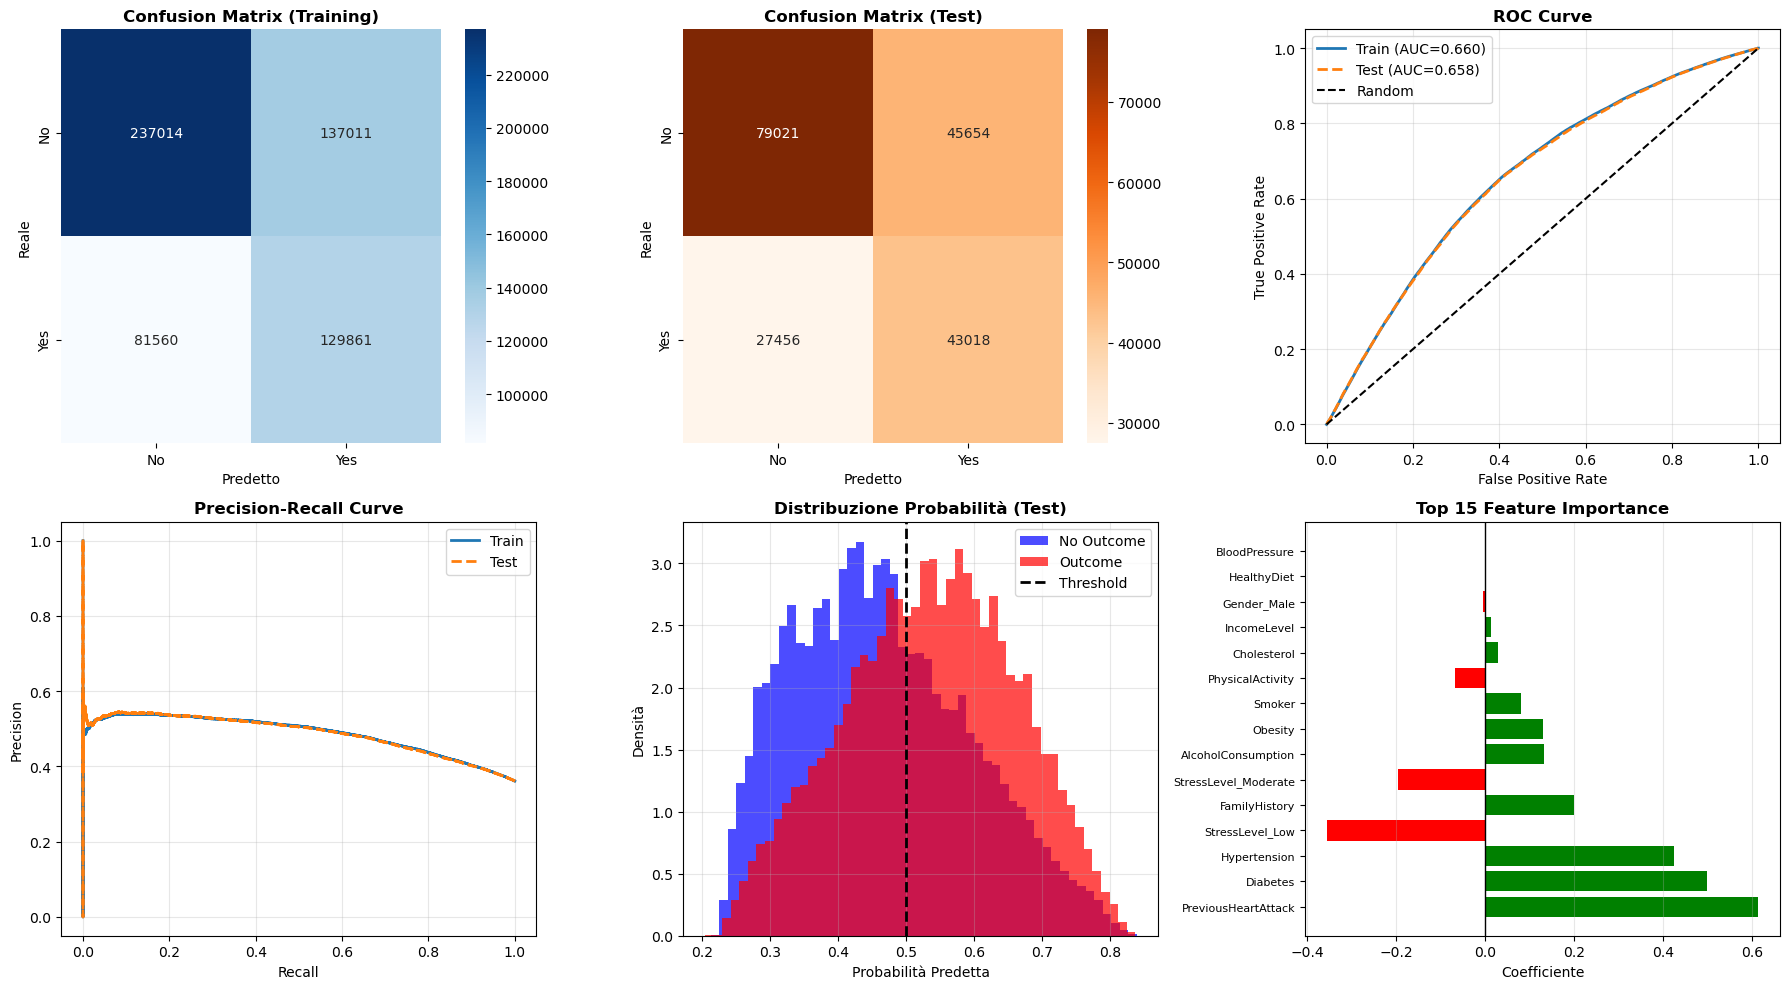

In [ ]:
# GRAFICI
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Confusion Matrix (Train)
cm_train = confusion_matrix(y_train, y_pred_train)
sb.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0, 0].set_xlabel('Predetto')
axes[0, 0].set_ylabel('Reale')
axes[0, 0].set_title('Confusion Matrix (Training)', fontweight='bold')

# Confusion Matrix (Test)
cm_test = confusion_matrix(y_test, y_pred_test)
sb.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0, 1].set_xlabel('Predetto')
axes[0, 1].set_ylabel('Reale')
axes[0, 1].set_title('Confusion Matrix (Test)', fontweight='bold')

# ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

axes[0, 2].plot(fpr_train, tpr_train, label=f'Train (AUC={roc_auc_score(y_train, y_pred_proba_train):.3f})',
                linewidth=2)
axes[0, 2].plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_score(y_test, y_pred_proba_test):.3f})',
                linewidth=2, linestyle='--')
axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curve', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)

axes[1, 0].plot(recall_train, precision_train, label='Train', linewidth=2)
axes[1, 0].plot(recall_test, precision_test, label='Test', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Distribuzione probabilità
axes[1, 1].hist(y_pred_proba_test[y_test==0], bins=50, alpha=0.7,
                label='No Outcome', color='blue', density=True)
axes[1, 1].hist(y_pred_proba_test[y_test==1], bins=50, alpha=0.7,
                label='Outcome', color='red', density=True)
axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 1].set_xlabel('Probabilità Predetta')
axes[1, 1].set_ylabel('Densità')
axes[1, 1].set_title('Distribuzione Probabilità (Test)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Importanza delle Feature
coefficients = best_model.named_steps['classifier'].coef_[0]

feature_names = []
feature_names.extend(numeric_features)
fitted_preprocessor = best_model.named_steps['preprocessor']
cat_features = fitted_preprocessor.named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)

feature_names.extend(cat_features)
feature_names.extend(binary_features)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False).head(15)

colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
axes[1, 2].barh(range(len(coef_df)), coef_df['Coefficient'], color=colors)
axes[1, 2].set_yticks(range(len(coef_df)))
axes[1, 2].set_yticklabels(coef_df['Feature'], fontsize=8)
axes[1, 2].set_xlabel('Coefficiente')
axes[1, 2].set_title('Top 15 Feature Importance', fontweight='bold')
axes[1, 2].axvline(0, color='black', linewidth=1)
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [58]:
print("ANALISI THRESHOLD")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8]
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_test >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"{thresh:<12.2f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")

ANALISI THRESHOLD
Threshold    Precision    Recall       F1          
0.30         0.377        0.967        0.542       
0.40         0.420        0.843        0.561       
0.50         0.485        0.610        0.541       
0.60         0.525        0.324        0.400       
0.70         0.542        0.098        0.167       
0.75         0.528        0.035        0.066       
0.80         0.557        0.005        0.010       


#### Analisi Threshold
Per i valori 0.3–0.4 possiamo notare un **Recall** molto alto (quasi tutti i casi positivi vengono individuati) e una **Precision** bassa con molti falsi positivi.
I valori 0.5–0.6 sono più bilanciati, mentre nelle soglie alte come 0.7–0.8 la **Precision** migliora leggermente, ma **Recall** si abbassa molto, quindi molti casi positivi vengono persi.

### XGBOOST

In [59]:
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # NO scaling per tree-based
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
         categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class ratio (Train): {(y_train==0).sum()/(y_train==1).sum():.2f}:1\n")

Training set: 439084 samples
Validation set: 146362 samples
Test set: 195149 samples
Class ratio (Train): 1.77:1



Si tiene conto dello sbilanciamento delle classi dando un peso maggiore alla classe minoritaria durante l'addestramento per bilanciare precision e recall senza la necessità di fare oversampling.

In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        tree_method='hist',
        n_jobs=-1
    ))
])

Scale pos weight: 1.77


Al fine di migliorare la robustezza del modello e ridurre il rischio di overfitting è stato scelto di utilizzare la Grid Search l'individuazione delle combinazioni di iperparametri ottimali.

In [ ]:
param_grid_xgb_light = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [4, 6],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__min_child_weight': [1, 3],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
    'classifier__gamma': [0],
}

# Combinazioni
n_combinations = (2 * 2 * 2 * 2 * 1 * 1 * 1)
n_folds = 5
total_fits = n_combinations * n_folds

print(f"Configurazione Grid Search:")
print(f"- Combinazioni parametri: {n_combinations}")
print(f"- Cross-validation folds: {n_folds}")
print(f"- Totale modelli da addestrare: {total_fits}")

grid_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb_light,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# No early stopping
grid_xgb.fit(X_train, y_train)

print(f"\nParametri migliori:")
for param, value in grid_xgb.best_params_.items():
    print(f"  - {param.replace('classifier__', '')}: {value}")
print(f"\nMiglior F1 score: {grid_xgb.best_score_:.4f}\n")

results_df = pd.DataFrame(grid_xgb.cv_results_)
results_df = results_df.sort_values('rank_test_score')

print("Migliori 5 configurazioni:")
cols = ['rank_test_score', 'mean_test_score', 'std_test_score',
        'param_classifier__max_depth', 'param_classifier__learning_rate',
        'param_classifier__n_estimators']
print(results_df[cols].head(5).to_string(index=False))
print()

Configurazione Grid Search:
- Combinazioni parametri: 16
- Cross-validation folds: 5
- Totale modelli da addestrare: 80
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Parametri migliori:
  - colsample_bytree: 0.8
  - gamma: 0
  - learning_rate: 0.05
  - max_depth: 6
  - min_child_weight: 1
  - n_estimators: 300
  - subsample: 0.8

Miglior F1 score: 0.6327

Migliori 5 configurazioni:
 rank_test_score  mean_test_score  std_test_score  param_classifier__max_depth  param_classifier__learning_rate  param_classifier__n_estimators
               1         0.632668        0.000984                            6                             0.05                             300
               2         0.632635        0.000976                            6                             0.05                             200
               3         0.632628        0.000957                            6                             0.05                             300
               4       

Dai risultati sopra riportati si può affermare che una profondità maggiore (`max_depth=6`) permette al modello di catturare relazioni più complesse, un learning rate più basso (`0.05`) riduce il rischio di overfitting e stabilizza l’F1-score e un numero di alberi maggiore (`n_estimators=300`) migliora leggermente la performance.\
La variazione molto piccola dello score tra le migliori configurazioni indica che il modello è robusto rispetto a piccole variazioni degli iperparametri.

In [ ]:
best_xgb = grid_xgb.best_estimator_

y_pred_train = best_xgb.predict(X_train)
y_pred_val = best_xgb.predict(X_val)
y_pred_test = best_xgb.predict(X_test)

y_proba_train = best_xgb.predict_proba(X_train)[:, 1]
y_proba_val = best_xgb.predict_proba(X_val)[:, 1]
y_proba_test = best_xgb.predict_proba(X_test)[:, 1]

# Metriche per ogni set
for name, y_true, y_pred, y_proba in [
    ("TRAINING", y_train, y_pred_train, y_proba_train),
    ("VALIDATION", y_val, y_pred_val, y_proba_val),
    ("TEST", y_test, y_pred_test, y_proba_test)
]:
    print(f"{name} SET:")
    print(classification_report(y_true, y_pred,
                              target_names=['No Outcome', 'Outcome'],
                              digits=3))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print(f"Recall Outcome: {recall_score(y_true, y_pred):.3f}")
    print(f"Precision Outcome: {precision_score(y_true, y_pred):.3f}")
    print(f"F1 Outcome: {f1_score(y_true, y_pred):.3f}\n")



TRAINING SET:
              precision    recall  f1-score   support

  No Outcome      0.854     0.554     0.672    280518
     Outcome      0.513     0.832     0.635    158566

    accuracy                          0.654    439084
   macro avg      0.683     0.693     0.653    439084
weighted avg      0.731     0.654     0.659    439084

ROC-AUC: 0.750
Recall Outcome: 0.832
Precision Outcome: 0.513
F1 Outcome: 0.635

VALIDATION SET:
              precision    recall  f1-score   support

  No Outcome      0.852     0.552     0.670     93507
     Outcome      0.512     0.830     0.633     52855

    accuracy                          0.653    146362
   macro avg      0.682     0.691     0.652    146362
weighted avg      0.729     0.653     0.657    146362

ROC-AUC: 0.719
Recall Outcome: 0.830
Precision Outcome: 0.512
F1 Outcome: 0.633

TEST SET:
              precision    recall  f1-score   support

  No Outcome      0.851     0.553     0.670    124675
     Outcome      0.512     0.829  

**Training Set**
* Il modello identifica la maggior parte dei positivi, ma include falsi positivi.
* Il punteggio ROC-AUC indica una buona capacità di discriminazione.

**Validation Set**
* Performance simile al training set
* Il punteggio ROC-AUC leggermente più basso può suggerire una leggera perdita di generalizzazione.

**Test Set**
* Il modello generalizza bene e non presenta overfitting.

In [63]:
fitted_preprocessor = best_xgb.named_steps['preprocessor']

# Feature names dopo preprocessing
feature_names = []
feature_names.extend(numeric_features)
cat_features = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names.extend(cat_features)
feature_names.extend(binary_features)

# 3 livelli di importanza
importance_weight = best_xgb.named_steps['classifier'].feature_importances_
importance_gain = best_xgb.named_steps['classifier'].get_booster().get_score(importance_type='gain')
importance_cover = best_xgb.named_steps['classifier'].get_booster().get_score(importance_type='cover')

# Conversione in array
importance_gain_array = np.array([importance_gain.get(f'f{i}', 0) for i in range(len(feature_names))])
importance_cover_array = np.array([importance_cover.get(f'f{i}', 0) for i in range(len(feature_names))])

# DataFrame completo
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': importance_weight,
    'Gain': importance_gain_array,
    'Cover': importance_cover_array
}).sort_values('Gain', ascending=False)

print("Top 15 Feature (ordinato per Gain):")
print(importance_df.head(15).to_string(index=False))
print()

Top 15 Feature (ordinato per Gain):
             Feature   Weight       Gain        Cover
 PreviousHeartAttack 0.286420 263.721283 15211.213867
            Diabetes 0.197787 182.112686 10763.642578
             Obesity 0.121387 111.767067 11186.970703
         IncomeLevel 0.116052 106.855309 10941.289062
        Hypertension 0.105355  97.005562  8943.728516
  AlcoholConsumption 0.069165  63.683655 10533.263672
         Cholesterol 0.025397  23.384308 13158.861328
              Smoker 0.022337  20.566813  9332.772461
                 Age 0.013101  12.063179  8483.439453
       BloodPressure 0.007040   6.481849  8697.920898
       FamilyHistory 0.006905   6.357644  2344.001953
         HealthyDiet 0.006318   5.817420  4543.362793
StressLevel_Moderate 0.006210   5.717599  4278.587402
     StressLevel_Low 0.005646   5.198944  2600.896240
    PhysicalActivity 0.005591   5.148259  3323.467773



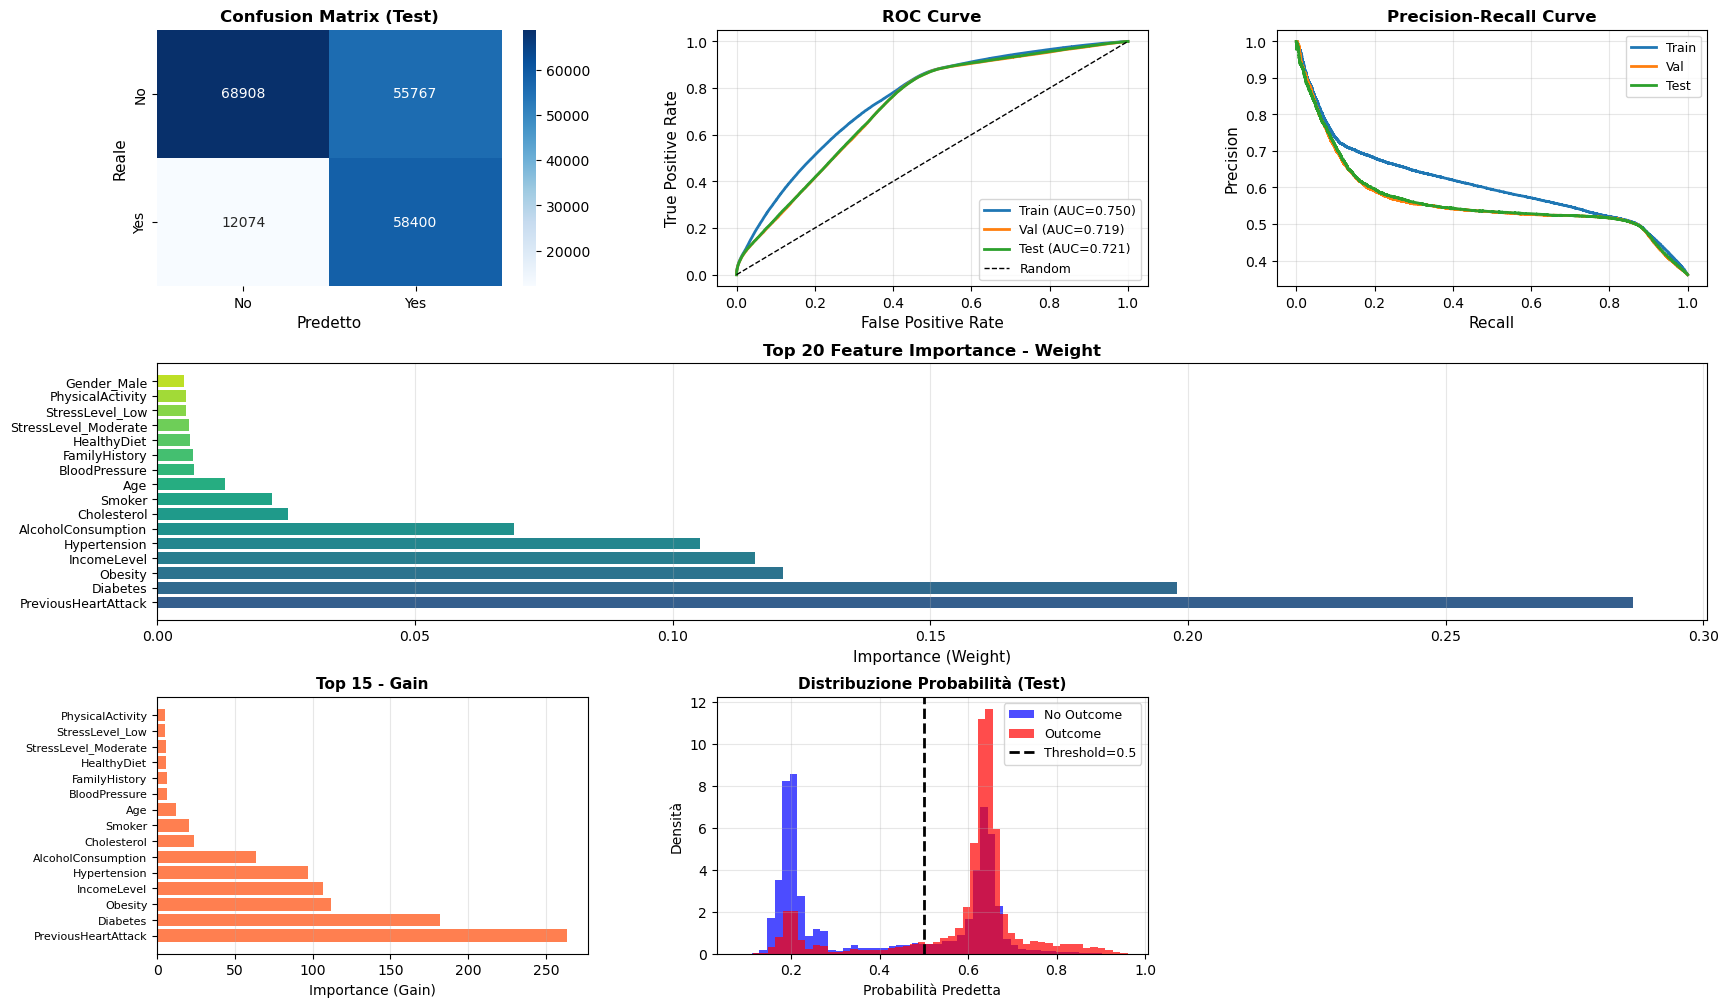

In [ ]:
# GRAFICI
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Confusion Matrix (Test)
ax1 = fig.add_subplot(gs[0, 0])
cm_test = confusion_matrix(y_test, y_pred_test)
sb.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax1.set_xlabel('Predetto', fontsize=11)
ax1.set_ylabel('Reale', fontsize=11)
ax1.set_title('Confusion Matrix (Test)', fontsize=12, fontweight='bold')

# ROC
ax2 = fig.add_subplot(gs[0, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

ax2.plot(fpr_train, tpr_train, label=f'Train (AUC={roc_auc_score(y_train, y_proba_train):.3f})', linewidth=2)
ax2.plot(fpr_val, tpr_val, label=f'Val (AUC={roc_auc_score(y_val, y_proba_val):.3f})', linewidth=2)
ax2.plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_score(y_test, y_proba_test):.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
prec_train, rec_train, _ = precision_recall_curve(y_train, y_proba_train)
prec_val, rec_val, _ = precision_recall_curve(y_val, y_proba_val)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_proba_test)

ax3.plot(rec_train, prec_train, label='Train', linewidth=2)
ax3.plot(rec_val, prec_val, label='Val', linewidth=2)
ax3.plot(rec_test, prec_test, label='Test', linewidth=2)
ax3.set_xlabel('Recall', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Feature Importance (Weight)
ax4 = fig.add_subplot(gs[1, :])
top_20 = importance_df.head(20)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20)))
ax4.barh(range(len(top_20)), top_20['Weight'], color=colors)
ax4.set_yticks(range(len(top_20)))
ax4.set_yticklabels(top_20['Feature'], fontsize=9)
ax4.set_xlabel('Importance (Weight)', fontsize=11)
ax4.set_title('Top 20 Feature Importance - Weight', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Feature Importance (Gain)
ax5 = fig.add_subplot(gs[2, 0])
top_15_gain = importance_df.nlargest(15, 'Gain')
ax5.barh(range(len(top_15_gain)), top_15_gain['Gain'], color='coral')
ax5.set_yticks(range(len(top_15_gain)))
ax5.set_yticklabels(top_15_gain['Feature'], fontsize=8)
ax5.set_xlabel('Importance (Gain)', fontsize=10)
ax5.set_title('Top 15 - Gain', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# Distribuzione Probabilità
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_proba_test[y_test==0], bins=50, alpha=0.7, label='No Outcome',
         color='blue', density=True)
ax6.hist(y_proba_test[y_test==1], bins=50, alpha=0.7, label='Outcome',
         color='red', density=True)
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
ax6.set_xlabel('Probabilità Predetta', fontsize=10)
ax6.set_ylabel('Densità', fontsize=10)
ax6.set_title('Distribuzione Probabilità (Test)', fontsize=11, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.show()

In [65]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8]
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<12}")
print("-"*60)

for thresh in thresholds:
    y_pred_thresh = (y_proba_test >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    support = np.sum(y_pred_thresh)
    print(f"{thresh:<12.2f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {support:<12}")


Threshold    Precision    Recall       F1           Support     
------------------------------------------------------------
0.30         0.492        0.881        0.631        126214      
0.40         0.501        0.865        0.634        121747      
0.50         0.512        0.829        0.633        114167      
0.60         0.521        0.739        0.611        99889       
0.70         0.706        0.104        0.181        10339       
0.75         0.771        0.072        0.132        6607        
0.80         0.835        0.046        0.088        3897        


#### Analisi Threshold
Per i valori 0.3–0.4 il modello individua la maggior parte dei positivi ma presenta anche molti falsi positivi.\
I valori 0.5–0.6 sono più bilanciati ma l'**F1-score** è leggermente inferiore rispetto al massimo.\
Nelle soglie alte come 0.7–0.8 la **Precision** è molto alta, ma **Recall** si abbassa molto.

### Confronto LR-XGBOOST

Si procede ora al confronto tra i risultati dei due modelli.

In [ ]:
# Logistic Regression
y_pred_train_lr = best_model.predict(X_train)  # best_model è il LogisticRegression
y_pred_test_lr = best_model.predict(X_test)
y_proba_train_lr = best_model.predict_proba(X_train)[:, 1]
y_proba_test_lr = best_model.predict_proba(X_test)[:, 1]

# XGBoost
y_pred_train_xgb = best_xgb.predict(X_train)
y_pred_test_xgb = best_xgb.predict(X_test)
y_proba_train_xgb = best_xgb.predict_proba(X_train)[:, 1]
y_proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Tabella comparativa metriche
def calculate_all_metrics(y_true, y_pred, y_proba):
    """Calcola tutte le metriche di interesse"""
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Outcome)': precision_score(y_true, y_pred),
        'Recall (Outcome)': recall_score(y_true, y_pred),
        'F1 (Outcome)': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'MCC': matthews_corrcoef(y_true, y_pred),  # Matthews Correlation Coefficient
        'Precision (No Outcome)': precision_score(y_true, y_pred, pos_label=0),
        'Recall (No Outcome)': recall_score(y_true, y_pred, pos_label=0),
    }

# Calcolo metriche per i due modelli
metrics_train_lr = calculate_all_metrics(y_train, y_pred_train_lr, y_proba_train_lr)
metrics_test_lr = calculate_all_metrics(y_test, y_pred_test_lr, y_proba_test_lr)
metrics_train_xgb = calculate_all_metrics(y_train, y_pred_train_xgb, y_proba_train_xgb)
metrics_test_xgb = calculate_all_metrics(y_test, y_pred_test_xgb, y_proba_test_xgb)

# DataFrame comparativo
comparison_df = pd.DataFrame({
    'Metrica': list(metrics_test_lr.keys()),
    'LR (Train)': list(metrics_train_lr.values()),
    'LR (Test)': list(metrics_test_lr.values()),
    'XGB (Train)': list(metrics_train_xgb.values()),
    'XGB (Test)': list(metrics_test_xgb.values()),
})

# Differenze
comparison_df['Δ (Test)'] = comparison_df['XGB (Test)'] - comparison_df['LR (Test)']
comparison_df['Winner'] = comparison_df['Δ (Test)'].apply(
    lambda x: 'XGB' if x > 0.01 else ('LR' if x < -0.01 else 'Tie')
)

print("TABELLA COMPLETA:")
print(comparison_df.to_string(index=False, float_format='%.4f'))
print()

# Riassunto
print("\n RIASSUNTO:")
winner_counts = comparison_df['Winner'].value_counts()
for winner, count in winner_counts.items():
    print(f"  {winner}: {count} metriche")

# Vincitore generale
if winner_counts.get('XGB', 0) > winner_counts.get('LR', 0):
    overall_winner = "XGBoost"
elif winner_counts.get('LR', 0) > winner_counts.get('XGB', 0):
    overall_winner = "Logistic Regression"
else:
    overall_winner = "Pareggio"

print(f"\n Vincitore (Test Set): {overall_winner}\n")

print("LOGISTIC REGRESSION - TEST SET:")
print("-"*80)
print(classification_report(y_test, y_pred_test_lr,
                          target_names=['No Outcome', 'Outcome'],
                          digits=4))

print("\n XGBOOST - TEST SET:")
print("-"*80)
print(classification_report(y_test, y_pred_test_xgb,
                          target_names=['No Outcome', 'Outcome'],
                          digits=4))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_test_lr)
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)

print("LOGISTIC REGRESSION:")
print(f"  True Negatives:  {cm_lr[0,0]:>8}")
print(f"  False Positives: {cm_lr[0,1]:>8}")
print(f"  False Negatives: {cm_lr[1,0]:>8}")
print(f"  True Positives:  {cm_lr[1,1]:>8}")

print("\nXGBOOST:")
print(f"  True Negatives:  {cm_xgb[0,0]:>8}")
print(f"  False Positives: {cm_xgb[0,1]:>8}")
print(f"  False Negatives: {cm_xgb[1,0]:>8}")
print(f"  True Positives:  {cm_xgb[1,1]:>8}")

print("\nDIFFERENZE (XGB - LR):")
print(f"  True Negatives:  {cm_xgb[0,0] - cm_lr[0,0]:>+8}")
print(f"  False Positives: {cm_xgb[0,1] - cm_lr[0,1]:>+8}")
print(f"  False Negatives: {cm_xgb[1,0] - cm_lr[1,0]:>+8}")
print(f"  True Positives:  {cm_xgb[1,1] - cm_lr[1,1]:>+8}")
print()

TABELLA COMPLETA:
               Metrica  LR (Train)  LR (Test)  XGB (Train)  XGB (Test)  Δ (Test) Winner
              Accuracy      0.6272     0.6254       0.6544      0.6524    0.0270    XGB
   Precision (Outcome)      0.4872     0.4851       0.5133      0.5115    0.0264    XGB
      Recall (Outcome)      0.6152     0.6104       0.8320      0.8287    0.2183    XGB
          F1 (Outcome)      0.5438     0.5406       0.6349      0.6326    0.0920    XGB
               ROC-AUC      0.6600     0.6579       0.7501      0.7206    0.0627    XGB
                   MCC      0.2403     0.2356       0.3764      0.3718    0.1362    XGB
Precision (No Outcome)      0.7445     0.7421       0.8537      0.8509    0.1088    XGB
   Recall (No Outcome)      0.6339     0.6338       0.5540      0.5527   -0.0811     LR


 RIASSUNTO:
  XGB: 7 metriche
  LR: 1 metriche

 Vincitore (Test Set): XGBoost

LOGISTIC REGRESSION - TEST SET:
----------------------------------------------------------------------------

**XGBoost** riduce fortemente i falsi negativi, aumentando la capacità di identificare gli `Outcome`, portando però ad un aumento dei falsi positivi.

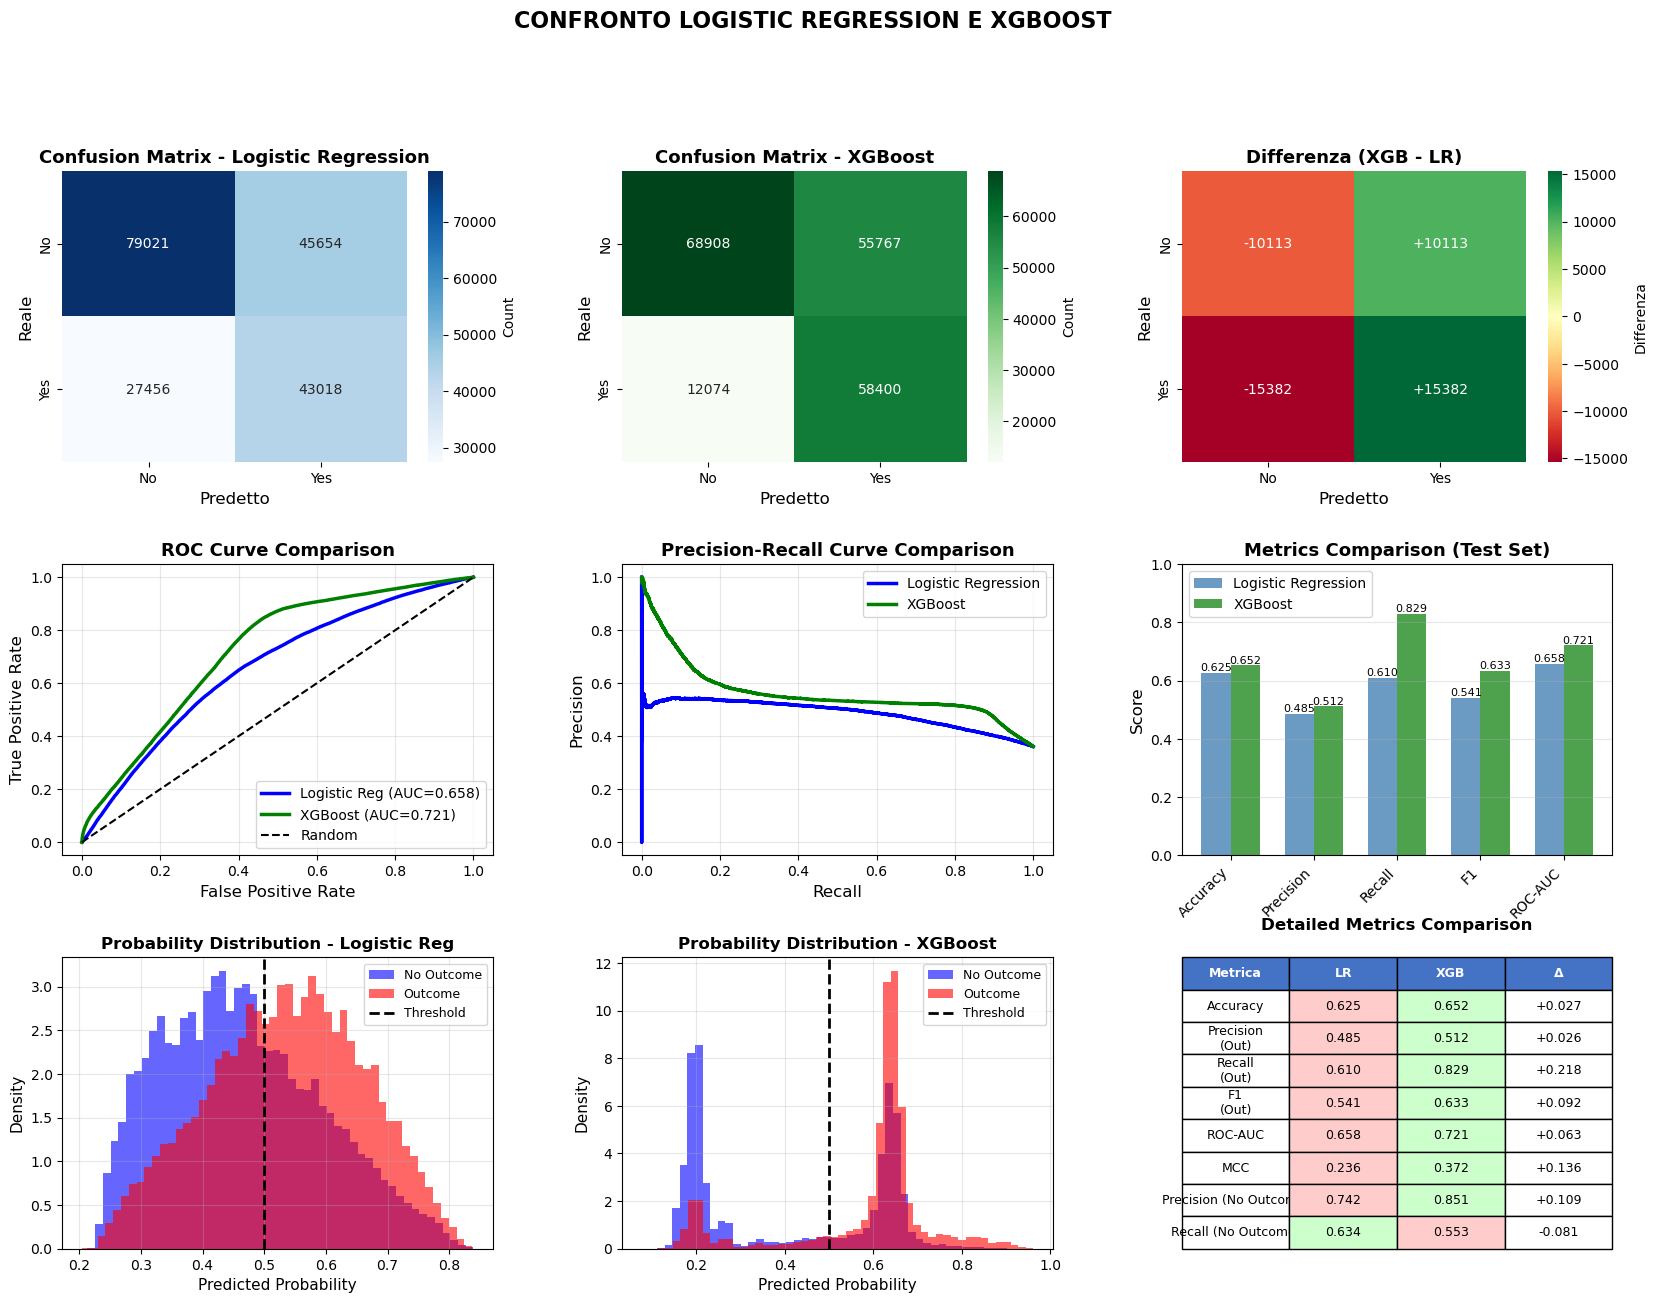

In [ ]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Confusion Matrix - Logistic Regression
ax1 = fig.add_subplot(gs[0, 0])
sb.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predetto', fontsize=12)
ax1.set_ylabel('Reale', fontsize=12)
ax1.set_title('Confusion Matrix - Logistic Regression', fontsize=13, fontweight='bold')

# Confusion Matrix - XGBoost
ax2 = fig.add_subplot(gs[0, 1])
sb.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'})
ax2.set_xlabel('Predetto', fontsize=12)
ax2.set_ylabel('Reale', fontsize=12)
ax2.set_title('Confusion Matrix - XGBoost', fontsize=13, fontweight='bold')

# 3. Difference Heatmap
ax3 = fig.add_subplot(gs[0, 2])
diff_cm = cm_xgb - cm_lr
sb.heatmap(diff_cm, annot=True, fmt='+d', cmap='RdYlGn', center=0, ax=ax3,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Differenza'})
ax3.set_xlabel('Predetto', fontsize=12)
ax3.set_ylabel('Reale', fontsize=12)
ax3.set_title('Differenza (XGB - LR)', fontsize=13, fontweight='bold')

# ROC Comparison
ax4 = fig.add_subplot(gs[1, 0])
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_test_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_test_xgb)

ax4.plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={roc_auc_score(y_test, y_proba_test_lr):.3f})',
         linewidth=2.5, color='blue')
ax4.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_proba_test_xgb):.3f})',
         linewidth=2.5, color='green')
ax4.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curve Comparison', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10, loc='lower right')
ax4.grid(True, alpha=0.3)

# Precision-Recall Comparison
ax5 = fig.add_subplot(gs[1, 1])
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_test_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_test_xgb)

ax5.plot(rec_lr, prec_lr, label='Logistic Regression', linewidth=2.5, color='blue')
ax5.plot(rec_xgb, prec_xgb, label='XGBoost', linewidth=2.5, color='green')
ax5.set_xlabel('Recall', fontsize=12)
ax5.set_ylabel('Precision', fontsize=12)
ax5.set_title('Precision-Recall Curve Comparison', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Metrics Bar Chart
ax6 = fig.add_subplot(gs[1, 2])
metrics_to_plot = ['Accuracy', 'Precision (Outcome)', 'Recall (Outcome)', 'F1 (Outcome)', 'ROC-AUC']
lr_values = [metrics_test_lr[m] for m in metrics_to_plot]
xgb_values = [metrics_test_xgb[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

bars1 = ax6.bar(x - width/2, lr_values, width, label='Logistic Regression', color='steelblue', alpha=0.8)
bars2 = ax6.bar(x + width/2, xgb_values, width, label='XGBoost', color='forestgreen', alpha=0.8)

ax6.set_ylabel('Score', fontsize=12)
ax6.set_title('Metrics Comparison (Test Set)', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels([m.replace(' (Outcome)', '') for m in metrics_to_plot], rotation=45, ha='right', fontsize=10)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim([0, 1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Probability Distribution - Logistic Regression
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(y_proba_test_lr[y_test==0], bins=50, alpha=0.6, label='No Outcome',
         color='blue', density=True)
ax7.hist(y_proba_test_lr[y_test==1], bins=50, alpha=0.6, label='Outcome',
         color='red', density=True)
ax7.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax7.set_xlabel('Predicted Probability', fontsize=11)
ax7.set_ylabel('Density', fontsize=11)
ax7.set_title('Probability Distribution - Logistic Reg', fontsize=12, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# Probability Distribution - XGBoost
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(y_proba_test_xgb[y_test==0], bins=50, alpha=0.6, label='No Outcome',
         color='blue', density=True)
ax8.hist(y_proba_test_xgb[y_test==1], bins=50, alpha=0.6, label='Outcome',
         color='red', density=True)
ax8.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax8.set_xlabel('Predicted Probability', fontsize=11)
ax8.set_ylabel('Density', fontsize=11)
ax8.set_title('Probability Distribution - XGBoost', fontsize=12, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

# Metrics Difference
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('tight')
ax9.axis('off')

# Dati per la tabella
table_data = []
for idx, row in comparison_df.iterrows():
    metric = row['Metrica'].replace(' (Outcome)', '\n(Out)')
    lr_val = f"{row['LR (Test)']:.3f}"
    xgb_val = f"{row['XGB (Test)']:.3f}"
    diff = f"{row['Δ (Test)']:+.3f}"
    winner = row['Winner']

    # Colore in base al vincitore
    if winner == 'XGB':
        color_lr = '#ffcccc'
        color_xgb = '#ccffcc'
    elif winner == 'LR':
        color_lr = '#ccffcc'
        color_xgb = '#ffcccc'
    else:
        color_lr = '#ffffcc'
        color_xgb = '#ffffcc'

    table_data.append([metric, lr_val, xgb_val, diff])

table = ax9.table(cellText=table_data,
                 colLabels=['Metrica', 'LR', 'XGB', 'Δ'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(1, len(table_data) + 1):
    winner = comparison_df.iloc[i-1]['Winner']
    if winner == 'XGB':
        table[(i, 1)].set_facecolor('#ffcccc')
        table[(i, 2)].set_facecolor('#ccffcc')
    elif winner == 'LR':
        table[(i, 1)].set_facecolor('#ccffcc')
        table[(i, 2)].set_facecolor('#ffcccc')
    else:
        table[(i, 1)].set_facecolor('#ffffcc')
        table[(i, 2)].set_facecolor('#ffffcc')

for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax9.set_title('Detailed Metrics Comparison', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('CONFRONTO LOGISTIC REGRESSION E XGBOOST',
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

In [68]:
# ANALISI ERRORI

# Errori modelli
lr_errors = y_test != y_pred_test_lr
xgb_errors = y_test != y_pred_test_xgb

both_wrong = lr_errors & xgb_errors
only_lr_wrong = lr_errors & ~xgb_errors
only_xgb_wrong = ~lr_errors & xgb_errors
both_correct = ~lr_errors & ~xgb_errors

print("ANALISI ERRORI:")
print(f"Entrambi corretti:        {np.sum(both_correct):>8} ({np.sum(both_correct)/len(y_test)*100:>5.2f}%)")
print(f"Entrambi sbagliati:       {np.sum(both_wrong):>8} ({np.sum(both_wrong)/len(y_test)*100:>5.2f}%)")
print(f"Solo LR sbagliato:        {np.sum(only_lr_wrong):>8} ({np.sum(only_lr_wrong)/len(y_test)*100:>5.2f}%)")
print(f"Solo XGB sbagliato:       {np.sum(only_xgb_wrong):>8} ({np.sum(only_xgb_wrong)/len(y_test)*100:>5.2f}%)")
print()

# Venn Diagram dei dati
print("SOVRAPPOSIZIONE ERRORI:")
agreement = np.sum(y_pred_test_lr == y_pred_test_xgb) / len(y_test) * 100
print(f"Accordo nelle predizioni: {agreement:.2f}%")
print(f"Disaccordo:               {100-agreement:.2f}%")
print()

ANALISI ERRORI:
Entrambi corretti:          102517 (52.53%)
Entrambi sbagliati:          48319 (24.76%)
Solo LR sbagliato:           24791 (12.70%)
Solo XGB sbagliato:          19522 (10.00%)

SOVRAPPOSIZIONE ERRORI:
Accordo nelle predizioni: 77.29%
Disaccordo:               22.71%



Dai risultati si può evincere che XGBoost fa meno errori unici rispetto a Logistic Regression e più della metà delle predizioni sono corrette per entrambi i modelli.

In [69]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8]

print("LOGISTIC REGRESSION:")
print(f"{'Thresh':<8} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Predicted+':<12}")

for thresh in thresholds:
    y_pred_thresh = (y_proba_test_lr >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    n_pos = np.sum(y_pred_thresh)
    print(f"{thresh:<8.1f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {n_pos:<12}")

print("\nXGBOOST:")
print(f"{'Thresh':<8} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Predicted+':<12}")

for thresh in thresholds:
    y_pred_thresh = (y_proba_test_xgb >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    n_pos = np.sum(y_pred_thresh)
    print(f"{thresh:<8.1f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {n_pos:<12}")

print()

print("RISULTATI CONFRONTO:")
print(f"\nVincitore: {overall_winner}")
print(f"Differenza media metriche: {comparison_df['Δ (Test)'].abs().mean():.4f}")
print(f"Miglior ROC-AUC: {'XGBoost' if metrics_test_xgb['ROC-AUC'] > metrics_test_lr['ROC-AUC'] else 'Logistic Regression'} "
      f"({max(metrics_test_xgb['ROC-AUC'], metrics_test_lr['ROC-AUC']):.4f})")
print(f"Miglior F1: {'XGBoost' if metrics_test_xgb['F1 (Outcome)'] > metrics_test_lr['F1 (Outcome)'] else 'Logistic Regression'} "
      f"({max(metrics_test_xgb['F1 (Outcome)'], metrics_test_lr['F1 (Outcome)']):.4f})")

LOGISTIC REGRESSION:
Thresh   Precision    Recall       F1           Predicted+  
0.3      0.377        0.967        0.542        180739      
0.4      0.420        0.843        0.561        141231      
0.5      0.485        0.610        0.541        88672       
0.6      0.525        0.324        0.400        43472       
0.7      0.542        0.098        0.167        12803       
0.8      0.528        0.035        0.066        4715        
0.8      0.557        0.005        0.010        607         

XGBOOST:
Thresh   Precision    Recall       F1           Predicted+  
0.3      0.492        0.881        0.631        126214      
0.4      0.501        0.865        0.634        121747      
0.5      0.512        0.829        0.633        114167      
0.6      0.521        0.739        0.611        99889       
0.7      0.706        0.104        0.181        10339       
0.8      0.771        0.072        0.132        6607        
0.8      0.835        0.046        0.088        3897  

Si può concludere che XGBoost offre migliori prestazioni complessive rispetto a Logistic Regression.

## Riduzione del dataset
A posteri dell'analisi svolta nei capitoli precedenti, sono state selezionate le feature maggiormente correlate all'output e, a partire da esse è stato creato un nuovo dataset ridotto contenente esclusivamente queste variabili.

In [ ]:
reducedDataset = dataset.drop(columns=['Age', 'Gender', 'Smoker', 'Cholesterol', 'PhysicalActivity',
                                       'HealthyDiet', 'BloodPressure', 'FamilyHistory', 'StressLevel'])
reducedDataset

Hypertension  Diabetes  Obesity  AlcoholConsumption  \
State     PatientID                                                        
China     1                 False     False       32                True   
          2                  True     False       24               False   
          3                 False     False       24               False   
          4                 False      True       24                True   
          5                 False     False       24               False   
...                           ...       ...      ...                 ...   
Indonesia 158351            False      True       24                True   
          158352            False      True       24                True   
          158353            False      True       24                True   
          158354            False      True       24                True   
          158355            False      True       24                True   

                     IncomeLevel  PreviousHeartAttack  Outcome  
State     PatientID                                             
China     1             0.000000                False    False  
          2            40.000000                False    False  
          3           100.000000                False    False  
          4             0.000000                 True    False  
          5            40.000000                False    False  
...                          ...                  ...      ...  
Indonesia 158351       24.444444                False    False  
          158352        0.000000                False     True  
          158353       24.444444                 True     True  
          158354       24.444444                 True     True  
          158355       24.444444                False    False  

[780595 rows x 7 columns]

## XGBoost su dataset ridotto
Viene ora applicato XGBoost come sopra ma sul nuovo dataset ottenuto.

In [71]:
X = reducedDataset.drop('Outcome', axis=1)
y = reducedDataset['Outcome'].astype(int)

numeric_features = ['Obesity', 'IncomeLevel']
binary_features = ['Hypertension', 'Diabetes',
                   'AlcoholConsumption', 'PreviousHeartAttack']

xgbR_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features)
    ]
)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class ratio (train): {(y_train==0).sum()/(y_train==1).sum():.2f}:1\n")

Training set: 439084 samples
Validation set: 146362 samples
Test set: 195149 samples
Class ratio (train): 1.77:1



In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgbR_pipeline = Pipeline([
    ('preprocessor', xgbR_preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        tree_method='hist',  # più veloce
        n_jobs=-1
    ))
])

Scale pos weight: 1.77


In [ ]:
param_grid_xgbR_light = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [4, 6],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__min_child_weight': [1, 3],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
    'classifier__gamma': [0],
}

n_combinations = (2 * 2 * 2 * 2 * 1 * 1 * 1)
n_folds = 5
total_fits = n_combinations * n_folds

print(f"Configurazione Grid Search:")
print(f"- Combinazioni parametri: {n_combinations}")
print(f"- Cross-validation folds: {n_folds}")
print(f"- Totale modelli da addestrare: {total_fits}")

grid_xgbR = GridSearchCV(
    xgbR_pipeline,
    param_grid_xgbR_light,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_xgbR.fit(X_train, y_train)

print(f"\nMigliori parametri:")
for param, value in grid_xgbR.best_params_.items():
    print(f"  - {param.replace('classifier__', '')}: {value}")
print(f"\nMiglior F1 score (CV): {grid_xgbR.best_score_:.4f}\n")

results_df = pd.DataFrame(grid_xgbR.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print("Migliori 5 configurazioni:")
cols = ['rank_test_score', 'mean_test_score', 'std_test_score',
        'param_classifier__max_depth', 'param_classifier__learning_rate',
        'param_classifier__n_estimators']
print(results_df[cols].head(5).to_string(index=False))
print()

Configurazione Grid Search:
- Combinazioni parametri: 16
- Cross-validation folds: 5
- Totale modelli da addestrare: 80
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Migliori parametri:
  - colsample_bytree: 0.8
  - gamma: 0
  - learning_rate: 0.1
  - max_depth: 6
  - min_child_weight: 3
  - n_estimators: 200
  - subsample: 0.8

Miglior F1 score (CV): 0.6311

Migliori 5 configurazioni:
 rank_test_score  mean_test_score  std_test_score  param_classifier__max_depth  param_classifier__learning_rate  param_classifier__n_estimators
               1         0.631143        0.001195                            6                             0.10                             200
               2         0.631055        0.001164                            6                             0.10                             200
               3         0.631032        0.001213                            6                             0.10                             300
               4   

In [ ]:
best_xgbR = grid_xgbR.best_estimator_

y_pred_train = best_xgbR.predict(X_train)
y_pred_val = best_xgbR.predict(X_val)
y_pred_test = best_xgbR.predict(X_test)

y_proba_train = best_xgbR.predict_proba(X_train)[:, 1]
y_proba_val = best_xgbR.predict_proba(X_val)[:, 1]
y_proba_test = best_xgbR.predict_proba(X_test)[:, 1]

for name, y_true, y_pred, y_proba in [
    ("TRAINING", y_train, y_pred_train, y_proba_train),
    ("VALIDATION", y_val, y_pred_val, y_proba_val),
    ("TEST", y_test, y_pred_test, y_proba_test)
]:
    print(f"{name} SET:")
    print(classification_report(y_true, y_pred,
                              target_names=['No Outcome', 'Outcome'],
                              digits=3))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print(f"Recall Outcome: {recall_score(y_true, y_pred):.3f}")
    print(f"Precision Outcome: {precision_score(y_true, y_pred):.3f}")
    print(f"F1 Outcome: {f1_score(y_true, y_pred):.3f}\n")

TRAINING SET:
              precision    recall  f1-score   support

  No Outcome      0.857     0.533     0.658    280518
     Outcome      0.505     0.843     0.632    158566

    accuracy                          0.645    439084
   macro avg      0.681     0.688     0.645    439084
weighted avg      0.730     0.645     0.648    439084

ROC-AUC: 0.725
Recall Outcome: 0.843
Precision Outcome: 0.505
F1 Outcome: 0.632

VALIDATION SET:
              precision    recall  f1-score   support

  No Outcome      0.857     0.533     0.657     93507
     Outcome      0.505     0.843     0.632     52855

    accuracy                          0.645    146362
   macro avg      0.681     0.688     0.645    146362
weighted avg      0.730     0.645     0.648    146362

ROC-AUC: 0.711
Recall Outcome: 0.843
Precision Outcome: 0.505
F1 Outcome: 0.632

TEST SET:
              precision    recall  f1-score   support

  No Outcome      0.855     0.533     0.657    124675
     Outcome      0.504     0.840  

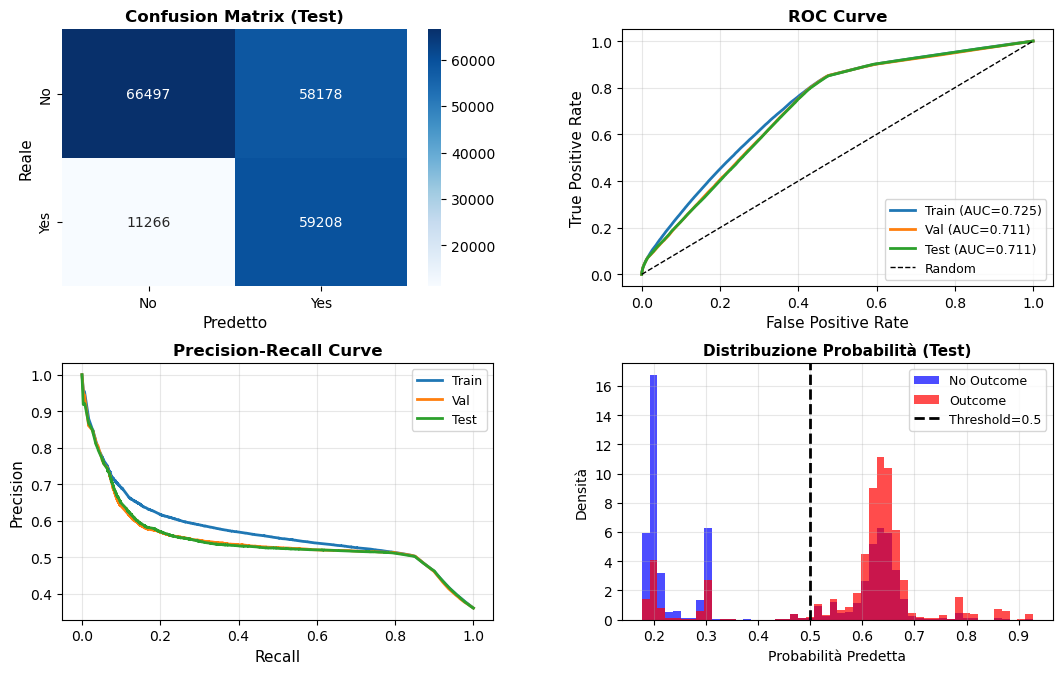

In [ ]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
cm_test = confusion_matrix(y_test, y_pred_test)
sb.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax1.set_xlabel('Predetto', fontsize=11)
ax1.set_ylabel('Reale', fontsize=11)
ax1.set_title('Confusion Matrix (Test)', fontsize=12, fontweight='bold')

# ROC
ax2 = fig.add_subplot(gs[0, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

ax2.plot(fpr_train, tpr_train, label=f'Train (AUC={roc_auc_score(y_train, y_proba_train):.3f})', linewidth=2)
ax2.plot(fpr_val, tpr_val, label=f'Val (AUC={roc_auc_score(y_val, y_proba_val):.3f})', linewidth=2)
ax2.plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_score(y_test, y_proba_test):.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Precision-Recall
ax3 = fig.add_subplot(gs[1, 0])
prec_train, rec_train, _ = precision_recall_curve(y_train, y_proba_train)
prec_val, rec_val, _ = precision_recall_curve(y_val, y_proba_val)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_proba_test)

ax3.plot(rec_train, prec_train, label='Train', linewidth=2)
ax3.plot(rec_val, prec_val, label='Val', linewidth=2)
ax3.plot(rec_test, prec_test, label='Test', linewidth=2)
ax3.set_xlabel('Recall', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Distribuzione Probabilità
ax6 = fig.add_subplot(gs[1, 1])
ax6.hist(y_proba_test[y_test==0], bins=50, alpha=0.7, label='No Outcome',
         color='blue', density=True)
ax6.hist(y_proba_test[y_test==1], bins=50, alpha=0.7, label='Outcome',
         color='red', density=True)
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
ax6.set_xlabel('Probabilità Predetta', fontsize=10)
ax6.set_ylabel('Densità', fontsize=10)
ax6.set_title('Distribuzione Probabilità (Test)', fontsize=11, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.show()

L’analisi della rilevanza delle feature ha evidenziato come l'outcome sia fortemente influenzato da un numero limitato di variabili. 
Sulla base di ciò, è stato addestrato un modello XGBoost utilizzando un dataset ridotto contenente soltanto le feature più rilevanti.\
Il modello ridotto ha mantenuto performance comparabili a quelle del modello completo, con una lieve riduzione della ROC-AUC ma curve Precision–Recall sostanzialmente sovrapponibili. Questo risultato suggerisce che molte delle variabili escluse apportavano un contributo marginale, mentre il segnale informativo principale è rappresentato da un sottoinsieme ristretto di feature.
A fronte delle analisi svolte, si può affermare quindi che l’impiego di modelli non lineari porta a un miglioramento delle prestazioni rispetto ai modelli lineari; questo suggerisce la presenza di relazioni non lineari nel dataset. Inoltre, la riduzione del numero di variabili consente di ottenere modelli più semplici e leggibili, mantenendo prestazioni molto simili a quelle del modello completo.